In [ ]:
%matplotlib inline


# Compare the effect of different scalers on data with outliers


Feature 0 (median income in a block) and feature 5 (number of households) of
the `California housing dataset
<https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html>`_ have very
different scales and contain some very large outliers. These two
characteristics lead to difficulties to visualize the data and, more
importantly, they can degrade the predictive performance of many machine
learning algorithms. Unscaled data can also slow down or even prevent the
convergence of many gradient-based estimators.

Indeed many estimators are designed with the assumption that each feature takes
values close to zero or more importantly that all features vary on comparable
scales. In particular, metric-based and gradient-based estimators often assume
approximately standardized data (centered features with unit variances). A
notable exception are decision tree-based estimators that are robust to
arbitrary scaling of the data.

This example uses different scalers, transformers, and normalizers to bring the
data within a pre-defined range.

Scalers are linear (or more precisely affine) transformers and differ from each
other in the way to estimate the parameters used to shift and scale each
feature.

``QuantileTransformer`` provides non-linear transformations in which distances
between marginal outliers and inliers are shrunk. ``PowerTransformer`` provides
non-linear transformations in which data is mapped to a normal distribution to
stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a per sample
transformation instead of a per feature transformation.

The following code is a bit verbose, feel free to jump directly to the analysis
of the results_.


In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.datasets import fetch_california_housing

print(__doc__)

dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target

# Take only 2 features to make visualization easier
# Feature of 0 has a long tail distribution.
# Feature 5 has a few but very large outliers.

X = X_full[:, [0, 5]]

distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('Data after power transformation (Box-Cox)',
     PowerTransformer(method='box-cox').fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

Automatically created module for IPython interactive environment


Two plots will be shown for each scaler/normalizer/transformer. The left
figure will show a scatter plot of the full data set while the right figure
will exclude the extreme values considering only 99 % of the data set,
excluding marginal outliers. In addition, the marginal distributions for each
feature will be shown on the side of the scatter plot.



In [2]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label="Median Income",
                      x1_label="Number of households",
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label="Median Income",
                      x1_label="Number of households",
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')


Original data
-------------

Each transformation is plotted showing two transformed features, with the
left plot showing the entire dataset, and the right zoomed-in to show the
dataset without the marginal outliers. A large majority of the samples are
compacted to a specific range, [0, 10] for the median income and [0, 6] for
the number of households. Note that there are some marginal outliers (some
blocks have more than 1200 households). Therefore, a specific pre-processing
can be very beneficial depending of the application. In the following, we
present some insights and behaviors of those pre-processing methods in the
presence of marginal outliers.



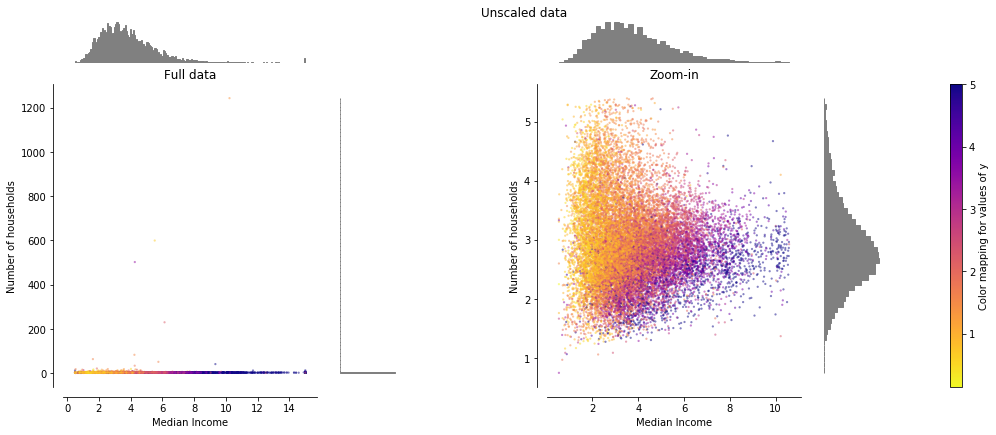

In [3]:
make_plot(0)

StandardScaler
--------------

``StandardScaler`` removes the mean and scales the data to unit variance.
However, the outliers have an influence when computing the empirical mean and
standard deviation which shrink the range of the feature values as shown in
the left figure below. Note in particular that because the outliers on each
feature have different magnitudes, the spread of the transformed data on
each feature is very different: most of the data lie in the [-2, 4] range for
the transformed median income feature while the same data is squeezed in the
smaller [-0.2, 0.2] range for the transformed number of households.

``StandardScaler`` therefore cannot guarantee balanced feature scales in the
presence of outliers.



In [ ]:
make_plot(1)

MinMaxScaler
------------

``MinMaxScaler`` rescales the data set such that all feature values are in
the range [0, 1] as shown in the right panel below. However, this scaling
compress all inliers in the narrow range [0, 0.005] for the transformed
number of households.

As ``StandardScaler``, ``MinMaxScaler`` is very sensitive to the presence of
outliers.



In [ ]:
make_plot(2)

MaxAbsScaler
------------

``MaxAbsScaler`` differs from the previous scaler such that the absolute
values are mapped in the range [0, 1]. On positive only data, this scaler
behaves similarly to ``MinMaxScaler`` and therefore also suffers from the
presence of large outliers.



In [ ]:
make_plot(3)

RobustScaler
------------

Unlike the previous scalers, the centering and scaling statistics of this
scaler are based on percentiles and are therefore not influenced by a few
number of very large marginal outliers. Consequently, the resulting range of
the transformed feature values is larger than for the previous scalers and,
more importantly, are approximately similar: for both features most of the
transformed values lie in a [-2, 3] range as seen in the zoomed-in figure.
Note that the outliers themselves are still present in the transformed data.
If a separate outlier clipping is desirable, a non-linear transformation is
required (see below).



In [ ]:
make_plot(4)

PowerTransformer
----------------

``PowerTransformer`` applies a power transformation to each feature to make
the data more Gaussian-like. Currently, ``PowerTransformer`` implements the
Yeo-Johnson and Box-Cox transforms. The power transform finds the optimal
scaling factor to stabilize variance and mimimize skewness through maximum
likelihood estimation. By default, ``PowerTransformer`` also applies
zero-mean, unit variance normalization to the transformed output. Note that
Box-Cox can only be applied to strictly positive data. Income and number of
households happen to be strictly positive, but if negative values are present
the Yeo-Johnson transformed is to be preferred.



In [ ]:
make_plot(5)
make_plot(6)

QuantileTransformer (Gaussian output)
-------------------------------------

``QuantileTransformer`` has an additional ``output_distribution`` parameter
allowing to match a Gaussian distribution instead of a uniform distribution.
Note that this non-parametetric transformer introduces saturation artifacts
for extreme values.



In [ ]:
make_plot(7)

QuantileTransformer (uniform output)
------------------------------------

``QuantileTransformer`` applies a non-linear transformation such that the
probability density function of each feature will be mapped to a uniform
distribution. In this case, all the data will be mapped in the range [0, 1],
even the outliers which cannot be distinguished anymore from the inliers.

As ``RobustScaler``, ``QuantileTransformer`` is robust to outliers in the
sense that adding or removing outliers in the training set will yield
approximately the same transformation on held out data. But contrary to
``RobustScaler``, ``QuantileTransformer`` will also automatically collapse
any outlier by setting them to the a priori defined range boundaries (0 and
1).



In [ ]:
make_plot(8)

Normalizer
----------

The ``Normalizer`` rescales the vector for each sample to have unit norm,
independently of the distribution of the samples. It can be seen on both
figures below where all samples are mapped onto the unit circle. In our
example the two selected features have only positive values; therefore the
transformed data only lie in the positive quadrant. This would not be the
case if some original features had a mix of positive and negative values.



In [ ]:
make_plot(9)

plt.show()